# Out of Africa model

In [1]:
import moments
import demes
import demesdraw
import matplotlib.pyplot as plt
import pickle
import gzip
from IPython.display import Markdown as md
import warnings

# Function for printing syntax-highlighted YAML demes models
# If there is a better way to do this, tell me!!
def print_model(file_path):
    with open(file_path) as f:
        lines = f.read()
    return md("```yaml\n" + lines + "```")
warnings.filterwarnings('ignore')

## Parametrized model

We are working with the out of Africa model.

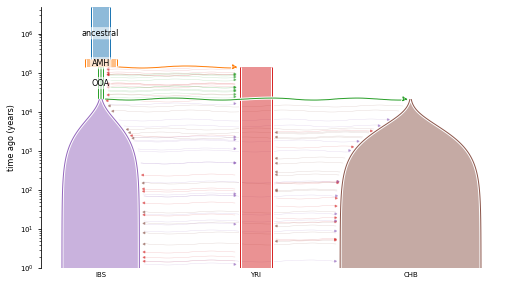

In [2]:
# this file contains the parametrization of the model
ooa_yml = "./gutenkunst_2009.yaml"
ooa = demes.load("./gutenkunst_2009.yaml")
demesdraw.tubes(ooa, log_time=True)

plt.show();

In [3]:
print_model(ooa_yml)

```yaml
# I modified to have IBS instead of CEU
description: The Gutenkunst et al. (2009) three-population model of
  human history, modified by replacing CEU with IBS.
doi:
  - https://doi.org/10.1371/journal.pgen.1000695
time_units: years
generation_time: 29
demes:
  - name: ancestral
    description: Equilibrium/root population
    epochs:
    - end_time: 220e3
      start_size: 7300
  - name: AMH
    description: Anatomically modern humans
    ancestors: [ancestral]
    epochs:
    - end_time: 140e3
      start_size: 12300
  - name: OOA
    description: Bottleneck out-of-Africa population
    ancestors: [AMH]
    epochs:
    - end_time: 21.2e3
      start_size: 2100
  - name: YRI
    description: Yoruba in Ibadan, Nigeria
    ancestors: [AMH]
    epochs:
    - start_size: 12300
      end_time: 0
  - name: IBS
    description: Iberian populations in Spain (IBS).
    ancestors: [OOA]
    epochs:
    - start_size: 1000
      end_size: 29725
      end_time: 0
  - name: CHB
    description: Han Chinese in Beijing, China
    ancestors: [OOA]
    epochs:
    - start_size: 510
      end_size: 54090
      end_time: 0
migrations:
  - demes: [YRI, OOA]
    rate: 25e-5
  - demes: [YRI, IBS]
    rate: 3e-5
  - demes: [YRI, CHB]
    rate: 1.9e-5
  - demes: [IBS, CHB]
    rate: 9.6e-5
```

# SFS inference

## Which paramaters do we want to infer?

I am following the [moments example](https://moments.readthedocs.io/en/latest/extensions/demes.html). I will infer the follwing parameters: TA, TB, and TF.



In [4]:
options = "./ooa_options.yaml"
print_model(options)


```yaml
parameters:
- name: TA
  description: Time before present of ancestral expansion
  values:
  - demes:
      ancestral:
        epochs:
          0: end_time
- name: TB
  description: Time of YRI-OOA split
  values:
  - demes:
      AMH:
        epochs:
          0: end_time
- name: TF
  description: Time of IBS-CHB split
  values:
  - demes:
      OOA:
       epochs:
         0: end_time
- name: Ne
  description: ancestral effective population size
  values:
  - demes:
      ancestral:
        epochs:
          0: start_size
- name: NA
  description: expansion size in AMH and YRI
  values:
  - demes:
      AMH:
        epochs:
          0: start_size
      YRI:
        epochs:
          0: start_size
- name: NB
  description: Bottleneck size for Eurasian populations
  values:
  - demes:
      OOA:
        epochs:
          0: start_size
- name: NEu0
  description: initial IBS size
  values:
  - demes:
      IBS:
        epochs:
          0: start_size
- name: NEuF
  description: final IBS size
  values:
  - demes:
      IBS:
        epochs:
          0: end_size
- name: NAs0
  description: initial CHB size
  values:
  - demes:
      CHB:
        epochs:
          0: start_size
- name: NAsF
  description: final CHB size
  values:
  - demes:
      CHB:
        epochs:
          0: end_size
- name: mAfB
  description: migration rate between Africa and OOA bottleneck
  values:
  - migrations:
      0: rate
- name: mAfEu
  description: migration rate between Africa and Europe
  values:
  - migrations:
      1: rate
- name: mAfAs
  description: migration rate between Africa and E Asia
  values:
  - migrations:
      2: rate
- name: mEuAs
  description: migration rate between Europe and E Asia
  values:
  - migrations:
      3: rate
constraints:
- params: [TA, TB]
  constraint: greater_than
- params: [TB, TF]
  constraint: greater_than
```

## The data

I [computed](../../data/210804-Compute-jSFS/) the joint SFS (all autosomes) for synonymous variants. I will project this SFS to a smaller sample size to make the optimization run faster.



In [11]:
sf = "../../data/210804-Compute-jSFS/data/spectrums/5d-csq-synonymous-spectrum.pkl.gz"
with gzip.open(sf, "rb") as f:
    sf = pickle.load(f)

print(sf.pop_ids)

['CHB', 'IBS', 'MXB', 'MXL', 'YRI']


In [12]:
# This spectrum is 5-dimensional, now I marginalize to keep
# the main populations
sf = sf.marginalize([2, 3])
print(sf.pop_ids)
print(sf.shape)

['CHB', 'IBS', 'YRI']
(51, 51, 51)


In [13]:
# project
n = 35
sf = sf.project([n, n, n])

# fold
sf = sf.fold()

In [14]:
sf.folded

True

## Optimization

Since we are using synonymous variants I will use the same scaled mutation rate as in the moments example.

In [16]:
uL = 0.14419746897690008
output = "./results/ooa_best_fit_model.yml"
ret = moments.Demes.Inference.optimize(
    deme_graph=ooa_yml,
    output=output,
    inference_options=options,
    data=sf,
    verbose=30,
    maxiter=1000,
    uL=uL,
    overwrite=True
)

150     , -17692.5    , array([ 246754     ,  127092     ,  23264.7    ,  7931.69    ,  13429.6    ,  2255.35    ,  1066.57    ,  32723      ,  491.347    ,  32122.6    ,  0.000231385,  2.72223e-05,  1.71675e-05,  8.80619e-05])
180     , -15646.8    , array([ 246600     ,  122818     ,  28707.6    ,  8928.19    ,  25964.6    ,  1875.72    ,  1039.33    ,  22478.6    ,  466.482    ,  46027.5    ,  0.000244381,  3.39072e-05,  1.73047e-05,  8.71403e-05])
210     , -14914.9    , array([ 373800     ,  104030     ,  36573.2    ,  9470.54    ,  26898.2    ,  1905.86    ,  1174.58    ,  33403.5    ,  417.352    ,  44838.2    ,  0.000259856,  3.58783e-05,  1.77711e-05,  0.000111734])
240     , -14807.2    , array([ 307529     ,  98741.1    ,  41284      ,  9434.83    ,  25667.1    ,  1901.66    ,  1206.66    ,  33358.6    ,  405.057    ,  45318.5    ,  0.000264232,  3.0576e-05 ,  1.62905e-05,  0.000124215])
270     , -14755.8    , array([ 310137     ,  91943.7    ,  40517.3    ,  9289.97    ,  

In [17]:
print('model fitted !')

model fitted !


## Results

In [18]:
param_names, opt_params, LL = ret
print("Log-likelihood:", -LL)
print("Best fit parameters")
for n, p in zip(param_names, opt_params):
    print(f"{n}\t{p:.3}")

Log-likelihood: -14189.826220977782
Best fit parameters
TA	3.01e+05
TB	8.7e+04
TF	4.47e+04
Ne	9.59e+03
NA	2.35e+04
NB	2.06e+03
NEu0	2.13e+03
NEuF	3.3e+04
NAs0	1.34e+03
NAsF	1.37e+04
mAfB	9.89e-05
mAfEu	3.26e-05
mAfAs	1.64e-05
mEuAs	7.69e-05


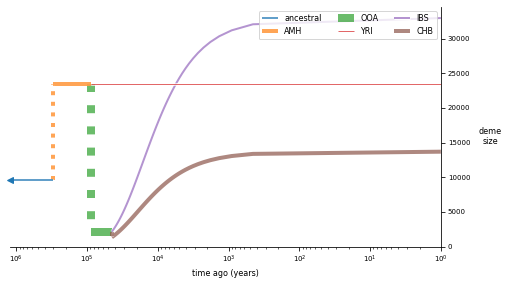

In [19]:
opt_model = demes.load(output)
demesdraw.size_history(opt_model, invert_x=True, log_time=True);

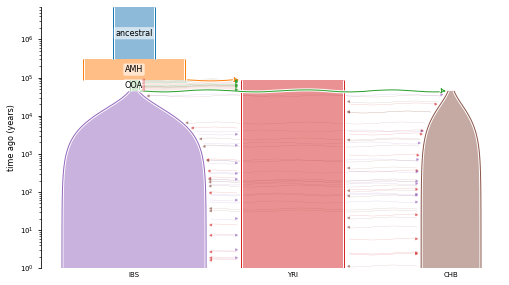

In [20]:
demesdraw.tubes(opt_model, log_time=True);

## Comparing SFS: model vs data

In [21]:
sf_expected = moments.Spectrum.from_demes(output, sf.pop_ids, sf.sample_sizes)

In [22]:
sf_expected.pop_ids

['CHB', 'IBS', 'YRI']

['YRI']


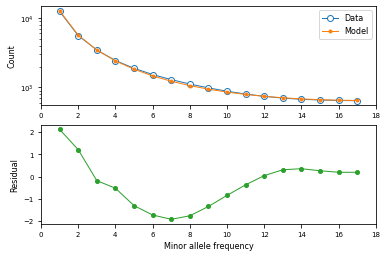

In [23]:
yr_mdl = sf_expected.marginalize([0, 1])
yr_data = sf.marginalize([0, 1])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['IBS']


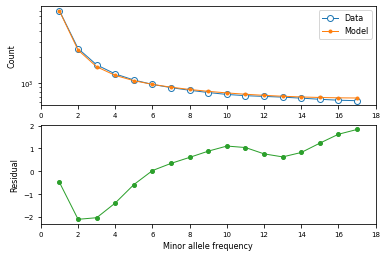

In [24]:
yr_mdl = sf_expected.marginalize([0, 2])
yr_data = sf.marginalize([0, 2])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['CHB']


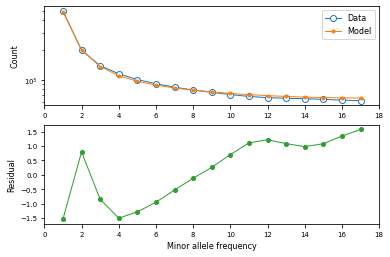

In [25]:
yr_mdl = sf_expected.marginalize([1, 2])
yr_data = sf.marginalize([1, 2])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['CHB', 'YRI']


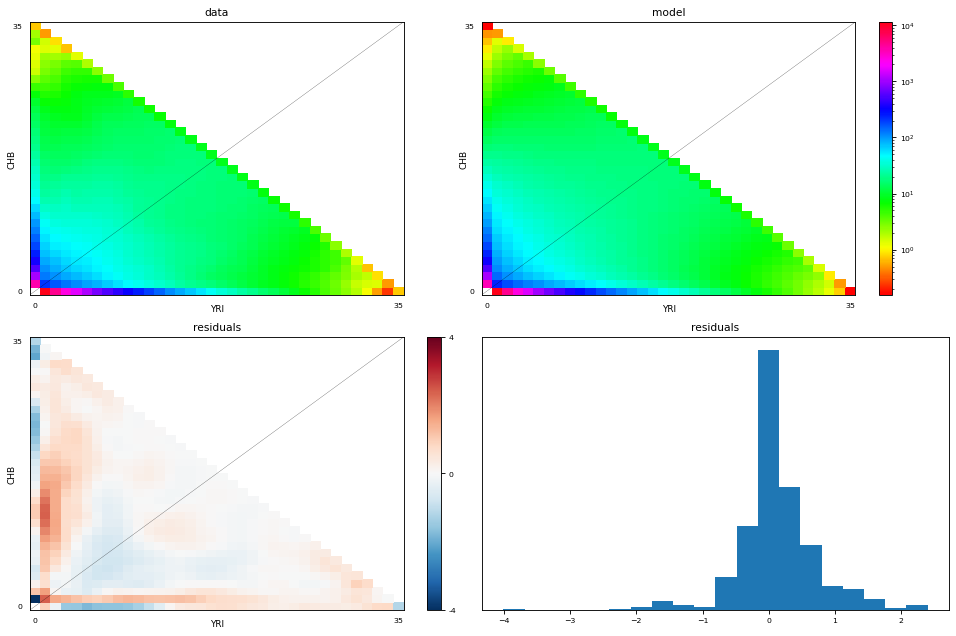

In [26]:

yr_mdl = sf_expected.marginalize([1])
yr_data = sf.marginalize([1])
print(yr_data.pop_ids)
plt.figure(figsize=(12, 8), dpi=80)
moments.Plotting.plot_2d_comp_multinom(yr_mdl, yr_data);

['CHB', 'IBS']


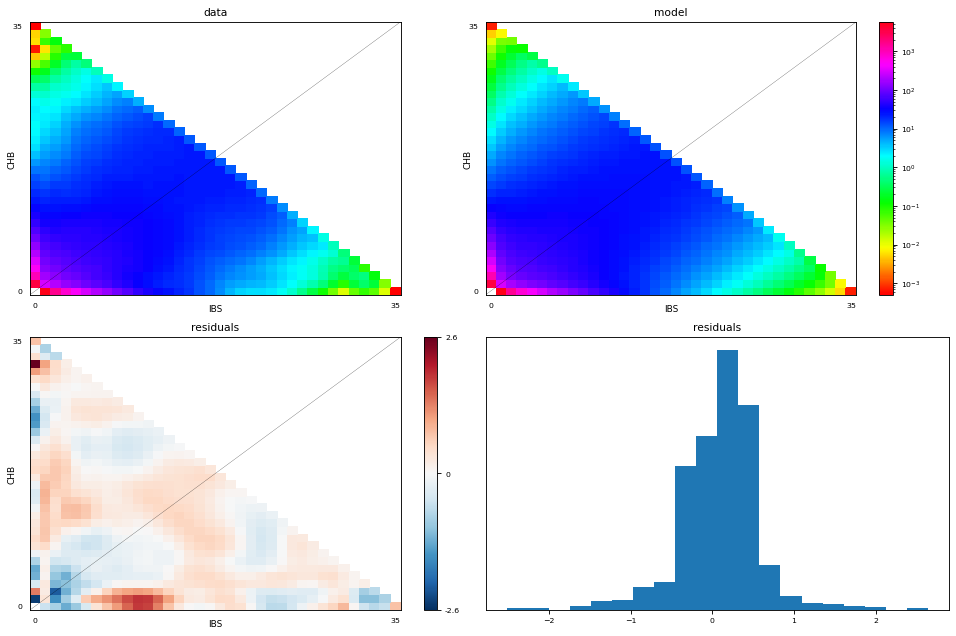

In [27]:
yr_mdl = sf_expected.marginalize([2])
yr_data = sf.marginalize([2])
print(yr_data.pop_ids)
plt.figure(figsize=(12, 8), dpi=80)
moments.Plotting.plot_2d_comp_multinom(yr_mdl, yr_data);